In [81]:
"""
    Importing dependencies
"""

import pymongo
import pprint
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import pytz

from dateutil import parser
from matplotlib.dates import date2num

In [14]:
"""
    Connecting to mongodb
"""

DATABASE = "twitter_database"
USERS_COL = "user_collection"
TWEETS_COL = "tweets_collection"
RETWEETS_COL = "retweets_collection"
REPLIES_COL = "replies_collection"

client = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = client[DATABASE]
users_col = mydb[USERS_COL]
tweets_col = mydb[TWEETS_COL]
retweets_col = mydb[RETWEETS_COL]
replies_col = mydb[REPLIES_COL]

In [51]:
""" 
    Lockdown phase demarcations
"""

utc=pytz.UTC

YEAR_BEGINNING = 'Jan 1 0:0:0 +0530 2020'
JANATA_CURFEW = 'Mar 22 0:0:0 +0530 2020'
PHASE_1_START = 'Mar 25 0:0:0 +0530 2020'
PHASE_2_START = 'Apr 15 0:0:0 +0530 2020'
PHASE_3_START = 'May 4 0:0:0 +0530 2020'
PHASE_4_START = 'May 18 0:0:0 +0530 2020'
UNLOCK_1_START = 'Jun 1 0:0:0 +0530 2020'
SCRAPE_DATE = 'Jun 17 0:0:0 +0530 2020'

year_beginning = parser.parse(YEAR_BEGINNING)
janata_curfew = parser.parse(JANATA_CURFEW)
phase_1_start = parser.parse(PHASE_1_START)
phase_2_start = parser.parse(PHASE_2_START)
phase_3_start = parser.parse(PHASE_3_START)
phase_4_start = parser.parse(PHASE_4_START)
unlock_1_start = parser.parse(UNLOCK_1_START)
scrape_date = parser.parse(SCRAPE_DATE)

PRE_LOCKDOWN = "Pre-lockdown"
PHASE_1 = "Phase-1"
PHASE_2 = "Phase-2"
PHASE_3 = "Phase-3"
PHASE_4 = "Phase-4"
UNLOCK_1 = "Unlock-1"

dur_dict = dict()
dur_dict[PRE_LOCKDOWN] = (phase_1_start - year_beginning).days
dur_dict[PHASE_1] = (phase_2_start - phase_1_start).days 
dur_dict[PHASE_2] = (phase_3_start - phase_2_start).days
dur_dict[PHASE_3] = (phase_4_start - phase_3_start).days
dur_dict[PHASE_4] = (unlock_1_start - phase_1_start).days
dur_dict[UNLOCK_1] = (scrape_date - unlock_1_start).days

In [52]:
def get_phase(status_date):
    status_date = utc.localize(parser.parse(status_date))
    
    if status_date < phase_1_start:
        return PRE_LOCKDOWN
    
    elif status_date < phase_2_start:
        return PHASE_1
    
    elif status_date < phase_3_start:
        return PHASE_2
    
    elif status_date < phase_4_start:
        return PHASE_3
    
    elif status_date < unlock_1_start:
        return PHASE_4
    
    else:
        return UNLOCK_1

In [54]:
"""
    Creating relevant dataframes
    - Phase wise aggregate
    - Day wise aggregate
""" 

day_dict = dict()
phase_dict = dict()
users_set = set()

for tweet in tweets_col.find():
    date = tweet["created_at"][:10]
    vals = day_dict.setdefault(date, [0,0,0])
    vals[0] = vals[0] + 1
    phase = get_phase(date)
    vals = phase_dict.setdefault(phase, [0,0,0])
    vals[0] = vals[0] + 1
    users_set.add(tweet["user"]["id"])
    
for retweet in retweets_col.find():
    date = retweet["created_at"][:10]
    vals = day_dict.setdefault(date, [0,0,0])
    vals[1] = vals[1] + 1
    phase = get_phase(date)
    vals = phase_dict.setdefault(phase, [0,0,0])
    vals[1] = vals[1] + 1
    users_set.add(retweet["user"]["id"])
    
for reply in replies_col.find():
    date = reply["created_at"][:10]
    vals = day_dict.setdefault(date, [0,0,0])
    vals[2] = vals[2] + 1
    phase = get_phase(date)
    vals = phase_dict.setdefault(phase, [0,0,0])
    vals[2] = vals[2] + 1
    users_set.add(reply["user"]["id"])
    
print("Aggregations completed")

Aggregations completed


In [95]:
""" Averaging it out and creating dataframes """

print(num_users)

daywise_data = []
phasewise_data = []

daywise_agg_cols = ['Date', 'Tweets', 'Retweets', 'Replies']
phasewise_agg_cols = ['Phase', 'Avg. tweets per user', 'Avg. retweets per user', 'Avg. replies per user']

for key, vals in day_dict.items():
    temp = [key]
    for val in vals:
        temp.append(val)
    daywise_data.append(temp)
    
for key, vals in phase_dict.items():
    temp = [key]
    for val in vals:
        temp.append(float(val)/(dur_dict[key]*num_users))
    phasewise_data.append(temp)

phasewise_data.reverse()

daywise_df = pd.DataFrame(daywise_data, columns = daywise_agg_cols)
phasewise_df = pd.DataFrame(phasewise_data, columns = phasewise_agg_cols)

daywise_df.to_csv('../dataset/daywise_agg.csv')
phasewise_df.to_csv('../dataset/phasewise_agg.csv')

126


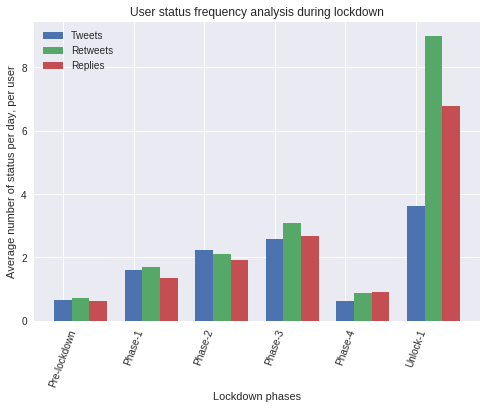

In [93]:
""" Plotting graph """

plt.style.use('seaborn')

X = np.arange(6)
plt.xticks(X, phasewise_df["Phase"])
plt.bar(X+0.0, phasewise_df['Avg. tweets per user'], width = 0.25, label='Tweets')
plt.bar(X+0.25, phasewise_df['Avg. retweets per user'], width = 0.25, label='Retweets')
plt.bar(X+0.5, phasewise_df['Avg. replies per user'], width = 0.25, label='Replies')

plt.xticks(rotation=70) 
plt.xlabel('Lockdown phases') 
plt.ylabel('Average number of status per day, per user') 
plt.title('User status frequency analysis during lockdown')
plt.legend()

""" Save plot """ 
plt.savefig('../results/freq_analysis.png',dpi=300,bbox_inches='tight') 

""" Display graph """
plt.show()